In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

/home/khairnar.as/.conda/envs/myenv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [230]:
mnist_x = mnist.data
mnist_y = mnist.target

In [232]:
import numpy as np
mnist_y = mnist_y.astype(int)
mnist_sub_x = []
mnist_sub_y = []

for i in range(10):
    idx = np.where(mnist_y == i)[0]
    selected_idx = np.random.choice(idx, 2000, replace=False)  # or np.random.choice(idx, 500, replace=False)

    mnist_sub_x.append(mnist_x[selected_idx])
    mnist_sub_y.append(mnist_y[selected_idx])  

mnist_sub_x = np.concatenate(mnist_sub_x, axis=0)
mnist_sub_y = np.concatenate(mnist_sub_y, axis=0)


In [233]:
mnist_sub_x = mnist_sub_x - np.mean(mnist_sub_x, axis=0)

In [234]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
mnist_sub_x =pca.fit_transform(mnist_sub_x)

In [235]:
mnist_sub_x.shape

(20000, 50)

In [236]:
N = mnist_sub_x.shape[0]

In [237]:
from scipy.spatial.distance import cdist

D = cdist(mnist_sub_x, mnist_sub_x, metric='euclidean')

In [238]:
from tqdm import tqdm

perplexcity = 30
# sigma_upper = 100
# sigma_lower = 1

# sigma_mid = (sigma_upper + sigma_lower) / 2

P = np.zeros((N, N))

for i in tqdm(range(N), desc="Computing P matrix"):
    D_i = D[i, :]
    H_diff = 1
    max_itr = 0
    p_ij = np.zeros((1, N))
    beta_lower = -np.inf
    beta_upper = np.inf
    beta = 0.6

    while abs(H_diff) > (10**(-5)) and max_itr<50:
        num = np.exp(-D_i * beta)
        # norm_denom = np.sum(num)

        p_ij = num
        H = - np.sum(p_ij * np.log2(p_ij + 1e-10))
        H_diff = H - np.log2(perplexcity)

        if H_diff > 0:
            beta_lower = beta

            if beta_upper == np.inf:
                beta *= 2
            else:
                beta = (beta + beta_upper) / 2

        if H_diff < 0:
            beta_upper = beta
            if beta_lower == -np.inf:
                beta /= 2
            else:
                beta = (beta + beta_lower) / 2
        max_itr += 1
    P[i] = p_ij

for i in range(N):
    P[i, i] = 0

P = (P + P.T) / 2

P = P / np.sum(P)

    

Computing P matrix: 100%|██████████| 20000/20000 [07:13<00:00, 46.16it/s]


In [137]:
import random

y = np.random.uniform(size=(5000, 2))

In [213]:
def calculate_grad(P, y):
    D = cdist(y, y, metric='euclidean')
    Q_num = 1 / (1 + D **2)
    Q = Q_num/np.sum(Q_num)
    L = (P - Q) * (Q_num)
    y_grad = (np.diag(np.sum(L, axis=1)) - L) @ y
    return y_grad

y_grad = calculate_grad(P, y)

  0%|          | 0/200 [00:00<?, ?it/s]

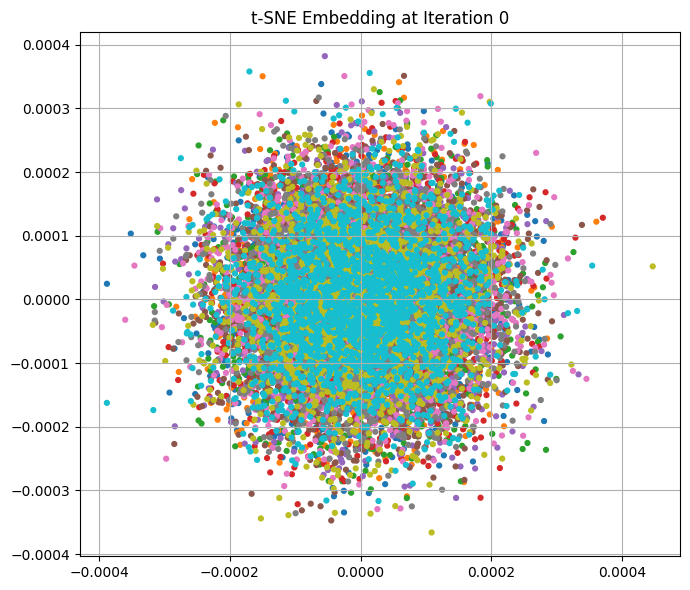

 10%|█         | 20/200 [05:46<51:46, 17.26s/it] 

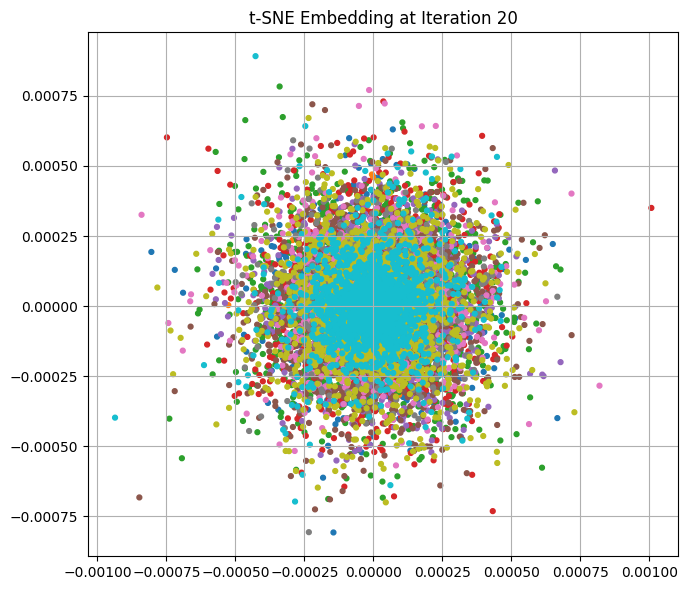

 20%|██        | 40/200 [11:30<45:58, 17.24s/it]

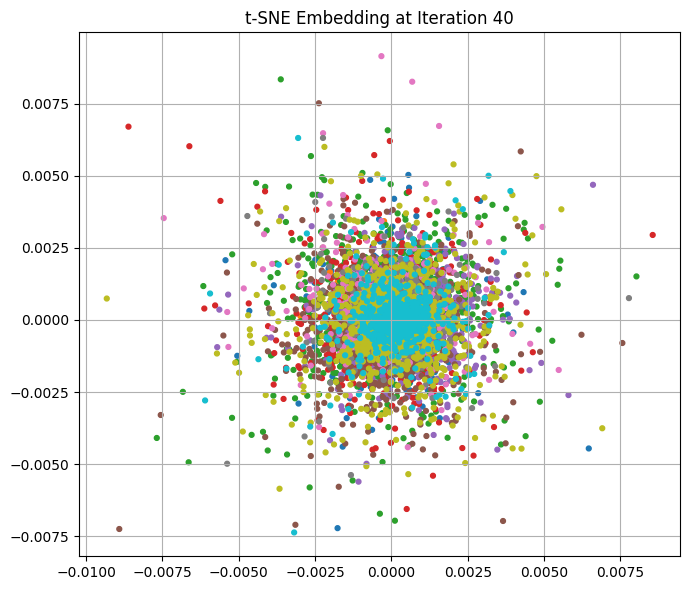

 30%|███       | 60/200 [17:17<40:14, 17.25s/it]

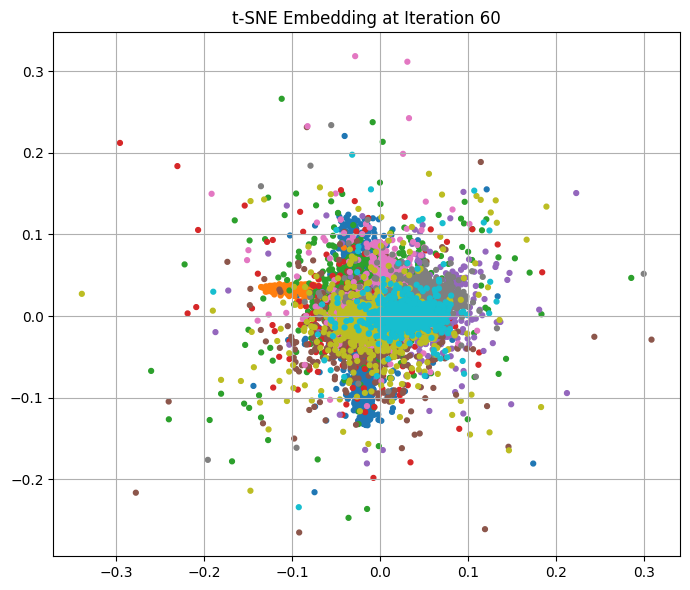

 40%|████      | 80/200 [23:06<35:00, 17.51s/it]

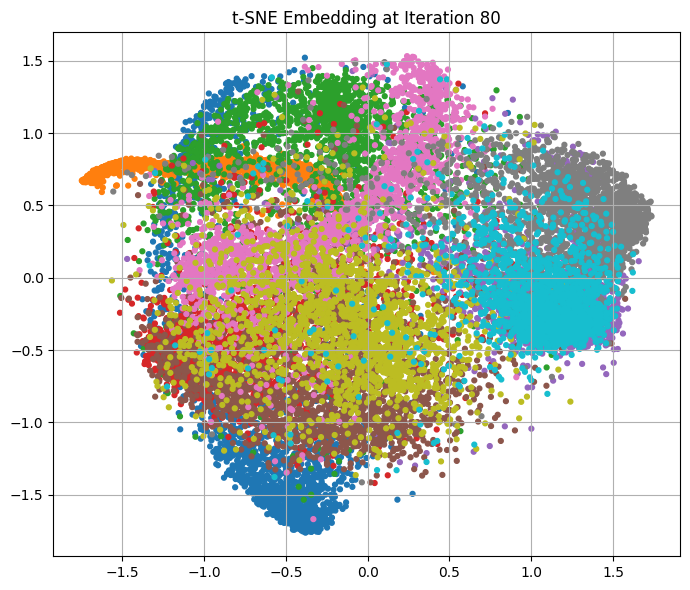

 50%|█████     | 100/200 [28:51<28:24, 17.05s/it]

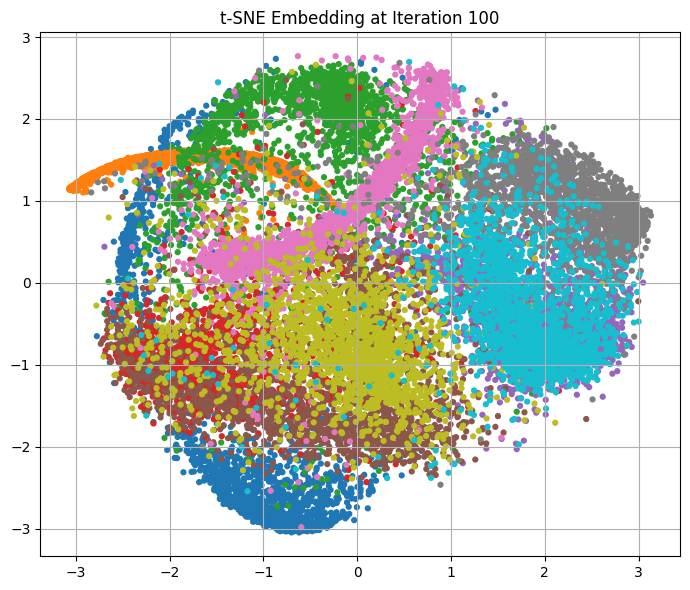

 60%|██████    | 120/200 [34:36<22:56, 17.20s/it]

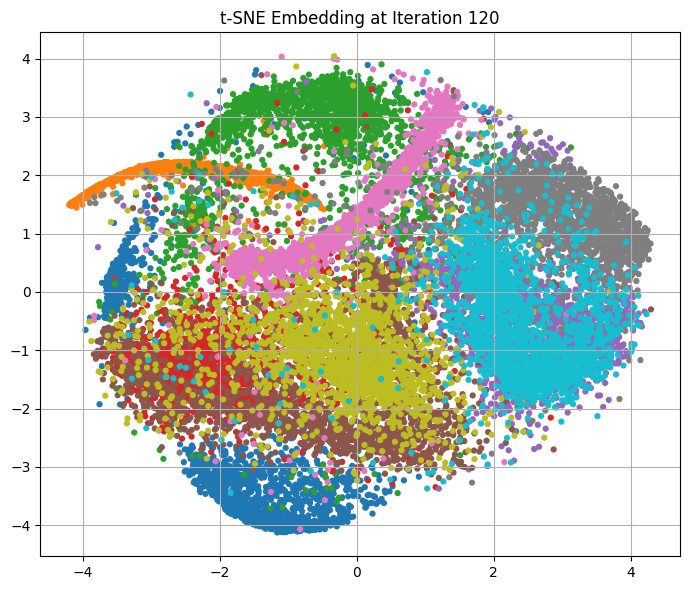

 70%|███████   | 140/200 [40:25<17:19, 17.32s/it]

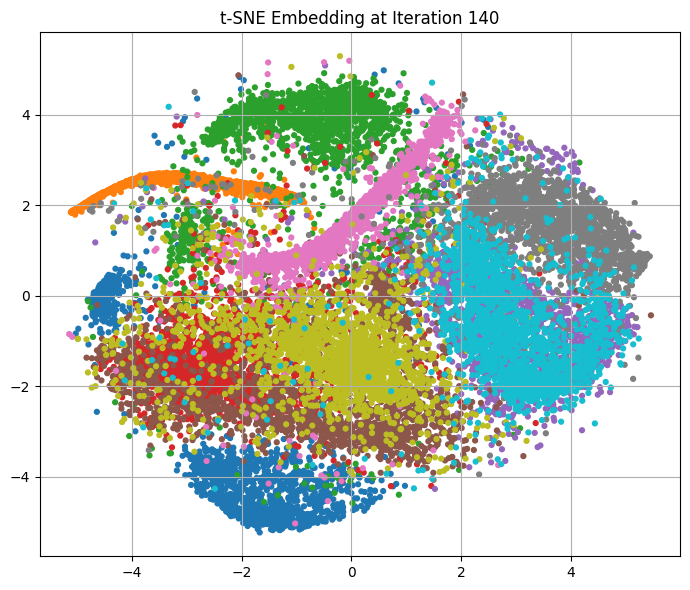

 80%|████████  | 160/200 [46:14<11:37, 17.43s/it]

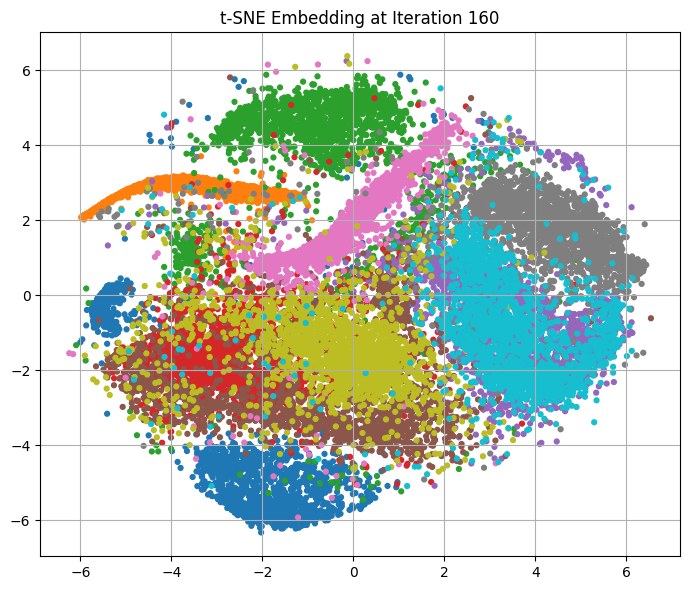

 90%|█████████ | 180/200 [52:01<05:58, 17.90s/it]

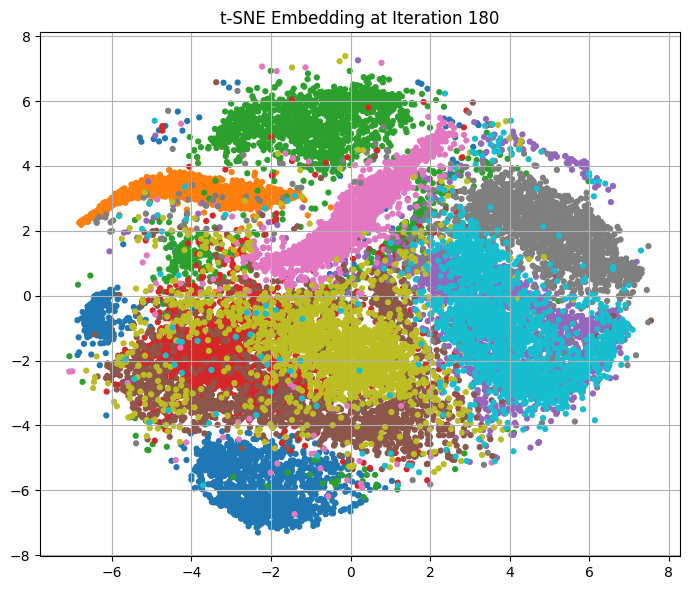

100%|██████████| 200/200 [57:50<00:00, 17.35s/it]


In [240]:
from tqdm import tqdm

max_itrs = 200
# y = 0.001 * np.random.uniform(size=(5000, 2))
y = 0.0001 * np.random.randn(N, 2)
lr = 650
y_incs = np.zeros((N, 2))
gains = np.ones((N, 2))
min_gain = 0.01


for i in tqdm(range(max_itrs)):
     y_grad = calculate_grad(P, y)
     gains = (gains + 0.2) * (np.sign(y_grad) != np.sign(y_incs)) + (gains * 0.8) * (np.sign(y_grad) == np.sign(y_incs))
     gains = np.maximum(gains, min_gain)
     y_incs = - lr * (gains * y_grad)
     y = y + y_incs
     y = y - np.mean(y, axis=0)


     if i % 20 == 0:
          plt.figure(figsize=(7, 6))
          plt.scatter(y[:, 0], y[:, 1], c=mnist_sub_y, cmap='tab10', s=12)
          plt.title(f"t-SNE Embedding at Iteration {i}")
          plt.grid(True)
          plt.tight_layout()
          plt.show()

In [210]:
np.max(y)

20718.32904749625